# Object Detection Serving Demo
This notebook shows how to serve a model from [TensorFlow Object Detection](https://github.com/tensorflow/models/tree/master/research/object_detection) via [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) and run inferences against it.


## TensorFlow Serving
From the TensorFlow Serving documentation
> TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.

The following diagram shows the high level architecture for the project.

![TF Serving Architecture](./tf-serving.png)

Since we will be using TensorFlow models, we can take advantage of the out-of-the-box integration mentioned above. By just providing the folder path to our model, the TensorFlow Serving process will be able to load and run our model with a rest and gRPC apis available. We will build a client for the rest api during this workshop, however, if you would like to build a gRPC client I would recommend checking out [this post](https://medium.com/innovation-machine/deploying-object-detection-model-with-tensorflow-serving-part-3-6a3d59c1e7c0) after this session.

Let's start by downloading a trained and servable model from the [TensorFlow Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). You may choose any model from the list that was trained on the COCO dataset.

In [ ]:
%%bash
MODEL_URL=http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
OUTPUT_DIRECTORY=/serving/object_detection/1

wget -nv -O model.tar.gz $MODEL_URL
tar -xvf model.tar.gz
mkdir -p $OUTPUT_DIRECTORY
cd <YOUR UNPACKED MODEL DIRECTORY>
find -name saved_model -exec mv {}/saved_model.pb {}/variables $OUTPUT_DIRECTORY \;

## Run TensorFlow Serving

To create a TensorFlow Serving instance:
1. Open a new terminal tab here in the Jupyter Lab UI.
2. Make sure to switch the shell to bash by running `bash`.
2. Use the following command to start the server.

```sh
tensorflow_model_server \
    --rest_api_port=8501 \
    --model_name=object_detection \
    --model_base_path=/serving/object_detection/ \
    --enable_batching
```

Now let's verify that the server is up and running via the curl command in the next cell.
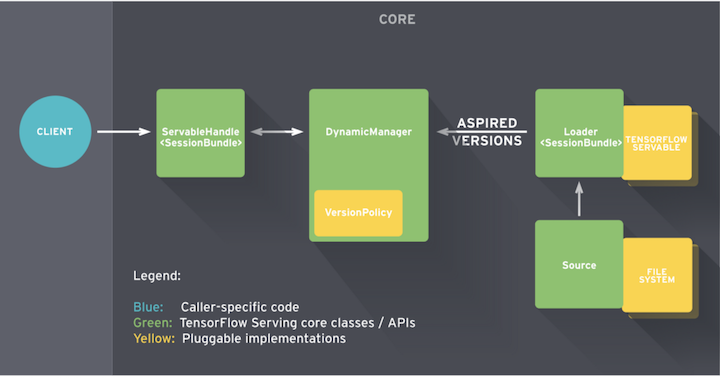

In [ ]:
!curl http://localhost:8501/v1/models/object_detection

# Building the Client

The images folder contains a few images we would like to identify objects in.

Feel free to add your own images to the folder but note that the images in the folder should all ideally have the same aspect ratio. All the images currently in the folder are square for simplicity. If you add images that aren't square you may want to adjust the resize options in the following cell so as to not distort the image.

To run an inference from our model over REST we will need to build a client.

The first step is to load and visualize the image data we have. The following cell defines functions to do just that.

In [ ]:
%matplotlib inline

import os

import numpy as np
from matplotlib import pyplot as plt
import PIL.Image

# load image data from disk into np arrays
def load_images(images):
    image_data = []
    for image in images:
        # Adjust resize here if aspect ratio is not 1:1
        loaded_image = PIL.Image.open(image).resize((500, 500))
        np_image = np.array(loaded_image)
        image_data.append(np_image)

    return image_data
 
# Image visualization code from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [ ]:
# Load and view all images in the directory
image_files = [os.path.join("images", filename) for filename in os.listdir("images")]
show_images(load_images(image_files), cols=1, titles=os.listdir("images"))

In [ ]:
import time

import requests
import object_detection.utils.visualization_utils as vis_util
from object_detection.utils import label_map_util


SERVER_URL = "http://localhost:8501"

# Create a mapping from class number to class name
category_index = label_map_util.create_category_index_from_labelmap("mscoco_label_map.pbtxt")

# Render the bounding box predictions from our object detection model onto our original images
def render_boxes(response, image_data):
    boxed_images = []
    for pred, image in zip(response["predictions"], image_data):
        boxes = pred["detection_boxes"]
        classes = pred["detection_classes"]
        scores = pred["detection_scores"]
        image_vis = vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.reshape(boxes, [100, 4]),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=3)

        boxed_images.append(image_vis)
    return boxed_images


# Run the query for a list of image file paths
def object_detect(url, *images):
    image_data = load_images(images)
    images_as_list = list(map(lambda x:  x.tolist(), image_data))
    payload = {"instances": images_as_list}
    res = requests.post("{}/v1/models/object_detection:predict".format(url), json=payload)

    res.raise_for_status()
    result = res.json()

    return render_boxes(result, image_data)

# Inference

Now we are ready to send off our images for object identification from our server. We can send them one at a time or classify the the entire directory with one query.

In [ ]:
# Single Image Inference
single_inference = object_detect(SERVER_URL, os.path.join("images", "street-crossing-1.jpg"))
show_images(single_inference, titles=["street.jpg"])

In [ ]:
# Batch Image Inference
image_names = os.listdir("images")
batch_inference = object_detect(SERVER_URL, *[os.path.join("images", image) for image in image_names])
show_images(batch_inference, titles=image_names)

# Conclusion

Running a pre trained an optimized model is straight forward enough. How would you go about exporting a servable artifact yourself?

In the next notebook we will do just that with a sample MNIST model.